<a href="https://www.kaggle.com/code/ravi20076/playgrounds4e08-datastore?scriptVersionId=191020336" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **IMPORTS AND INSTALLATIONS**

In [1]:
%%capture

!cp /kaggle/usr/lib/playgrounds4e08_regularimports/playgrounds4e08_regularimports.py myimports.py
!python myimports.py
from myimports import *

# **FOREWORD**

This kernel aims to engender the below tasks- <br>
1. Organize the train, original and test data in smaller files for easy and convenient data storage <br>
2. Develop appropriate feature engineering caveats for these datasets to directly use in my further steps <br>
3. Please find some useful discussions for this competition as below. They are incredibly informative in my opinion and act as references for the kernel-

- https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523439 <br> 
- https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523442 <br>
- https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523440 <br> 
- https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523705 <br> 

## **ORIGINAL DATA SOURCES**

I took the idea of using this dataset from the sources below- <br>
1. External Source- https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset <br> 
2. Kaggle source - https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523439 <br>

<br>Additionally, I use the supplementary dataset from the post link [here](https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523705) and append this to the existing data. I think we can consider sampling this data later based on our further requirements.

# **PREPROCESSING**

In [2]:
%%time 

version_nb   = 1
target       = "class"
visuals_req  = True
mapper       = {"e" : 0, "p" : 1}

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


## **DATA LOADING**

In [3]:
%%time 

PrintColor(f"\n{'=' * 20} DATA LOADING {'=' * 20}\n")

train  = pd.read_csv(f"/kaggle/input/playground-series-s4e8/train.csv").set_index("id")
test   = pd.read_csv(f"/kaggle/input/playground-series-s4e8/test.csv").set_index("id")
sub_fl = pd.read_csv(f"/kaggle/input/playground-series-s4e8/sample_submission.csv").set_index("id")
        
print(f"---> Loading secondary original data")
secondary_mushroom = fetch_ucirepo(id=848) 
original = \
pd.concat([pd.DataFrame(secondary_mushroom.data.features), 
           pd.DataFrame(secondary_mushroom.data.targets)
          ], axis=1)
original.index.name = "id"

print(f"---> Loading teritary original data")
orig = \
pd.read_csv(f"/kaggle/input/tertiary-mushroom-1-million-more-mushrooms/one_million_mushrooms.csv", sep = ";")

for df in [train, test, original, orig]:
    df.columns = df.columns.str.replace("-","")
    
cat_cols  = test.select_dtypes("object").columns
cont_cols = test.select_dtypes(float).columns

with np.printoptions(linewidth = 80):
    PrintColor("\n---> Category columns\n", color = Fore.RED)
    print(np.array(cat_cols))
    
PrintColor(f"\n\n---> Shapes = {train.shape} | {test.shape} | {original.shape} | {orig.shape} \n", 
           color = Fore.CYAN
          )

collect();
print();


==================== DATA LOADING ====================

---> Loading secondary original data
---> Loading teritary original data

---> Category columns

['capshape' 'capsurface' 'capcolor' 'doesbruiseorbleed' 'gillattachment'
 'gillspacing' 'gillcolor' 'stemroot' 'stemsurface' 'stemcolor' 'veiltype'
 'veilcolor' 'hasring' 'ringtype' 'sporeprintcolor' 'habitat' 'season']


---> Shapes = (3116945, 21) | (2077964, 20) | (61069, 21) | (1038000, 21) 


CPU times: user 17.7 s, sys: 5.04 s, total: 22.8 s
Wall time: 50.5 s


## **DATA PREPROCESSING**

Here, we carry out 2 steps for category columns- 
1. Replace all nulls with a new category- **missing** <br>
2. Replace noise elements in the competition dataset with a new category - **noise**

In [4]:
%%time 

PrintColor(f"\n{'=' * 20} DATA PREPROCESSING {'=' * 20}\n")

for df in [train, test, original, orig]:    
    df[cat_cols]  = df[cat_cols].fillna("missing")
    df[cont_cols] = df[cont_cols].astype(np.float32) 

print();
display(
    pd.DataFrame.from_dict(
        {"Train"    : train[cat_cols].nunique(), 
         "Test"     : test[cat_cols].nunique(),
         "Original" : original[cat_cols].nunique(),
         "Original2": orig[cat_cols].nunique(),
        }
    ).transpose().\
    style.
    set_caption(f"Unique values across category columns before preprocessing").\
    set_properties(**{"text-align": "center"})
)

for col in tqdm(cat_cols):
    unq_vals = \
    list(
        set(np.concatenate([train[col].unique(), test[col].unique()])).\
        difference(set(original[col].unique()))
    )

    train.loc[train[col].isin(unq_vals), col] = "noise"
    test.loc[test[col].isin(unq_vals), col]   = "noise"
    
print();
display(
    pd.DataFrame.from_dict(
        {"Train"    : train[cat_cols].nunique(), 
         "Test"     : test[cat_cols].nunique(),
         "Original" : original[cat_cols].nunique(),
         "Original2": orig[cat_cols].nunique(),
        }
    ).transpose().\
    style.
    set_caption(f"Unique values across category columns after preprocessing").\
    set_properties(**{"text-align": "center"})
)

df_dict = \
{"Train": train,
 "Test": test, 
 "Original": original, 
 "Original2": orig
}

print();
collect();


==================== DATA PREPROCESSING ====================




,capshape,capsurface,capcolor,doesbruiseorbleed,gillattachment,gillspacing,gillcolor,stemroot,stemsurface,stemcolor,veiltype,veilcolor,hasring,ringtype,sporeprintcolor,habitat,season
Train,75,84,79,27,79,49,64,39,61,60,23,25,24,41,33,53,4
Test,63,60,58,23,67,36,57,32,55,56,16,24,24,37,34,40,4
Original,7,12,12,2,8,4,12,6,9,13,2,7,2,9,8,8,4
Original2,7,12,12,2,8,4,12,6,9,13,2,7,2,9,8,8,4


  0%|          | 0/17 [00:00<?, ?it/s]

,capshape,capsurface,capcolor,doesbruiseorbleed,gillattachment,gillspacing,gillcolor,stemroot,stemsurface,stemcolor,veiltype,veilcolor,hasring,ringtype,sporeprintcolor,habitat,season
Train,8,13,13,3,9,5,13,7,10,14,3,8,3,10,9,9,4
Test,8,13,13,3,9,5,13,7,10,14,3,8,3,10,9,9,4
Original,7,12,12,2,8,4,12,6,9,13,2,7,2,9,8,8,4
Original2,7,12,12,2,8,4,12,6,9,13,2,7,2,9,8,8,4



CPU times: user 33.5 s, sys: 3.98 s, total: 37.5 s
Wall time: 37.4 s


## **BASELINE VISUALS**

0it [00:00, ?it/s]

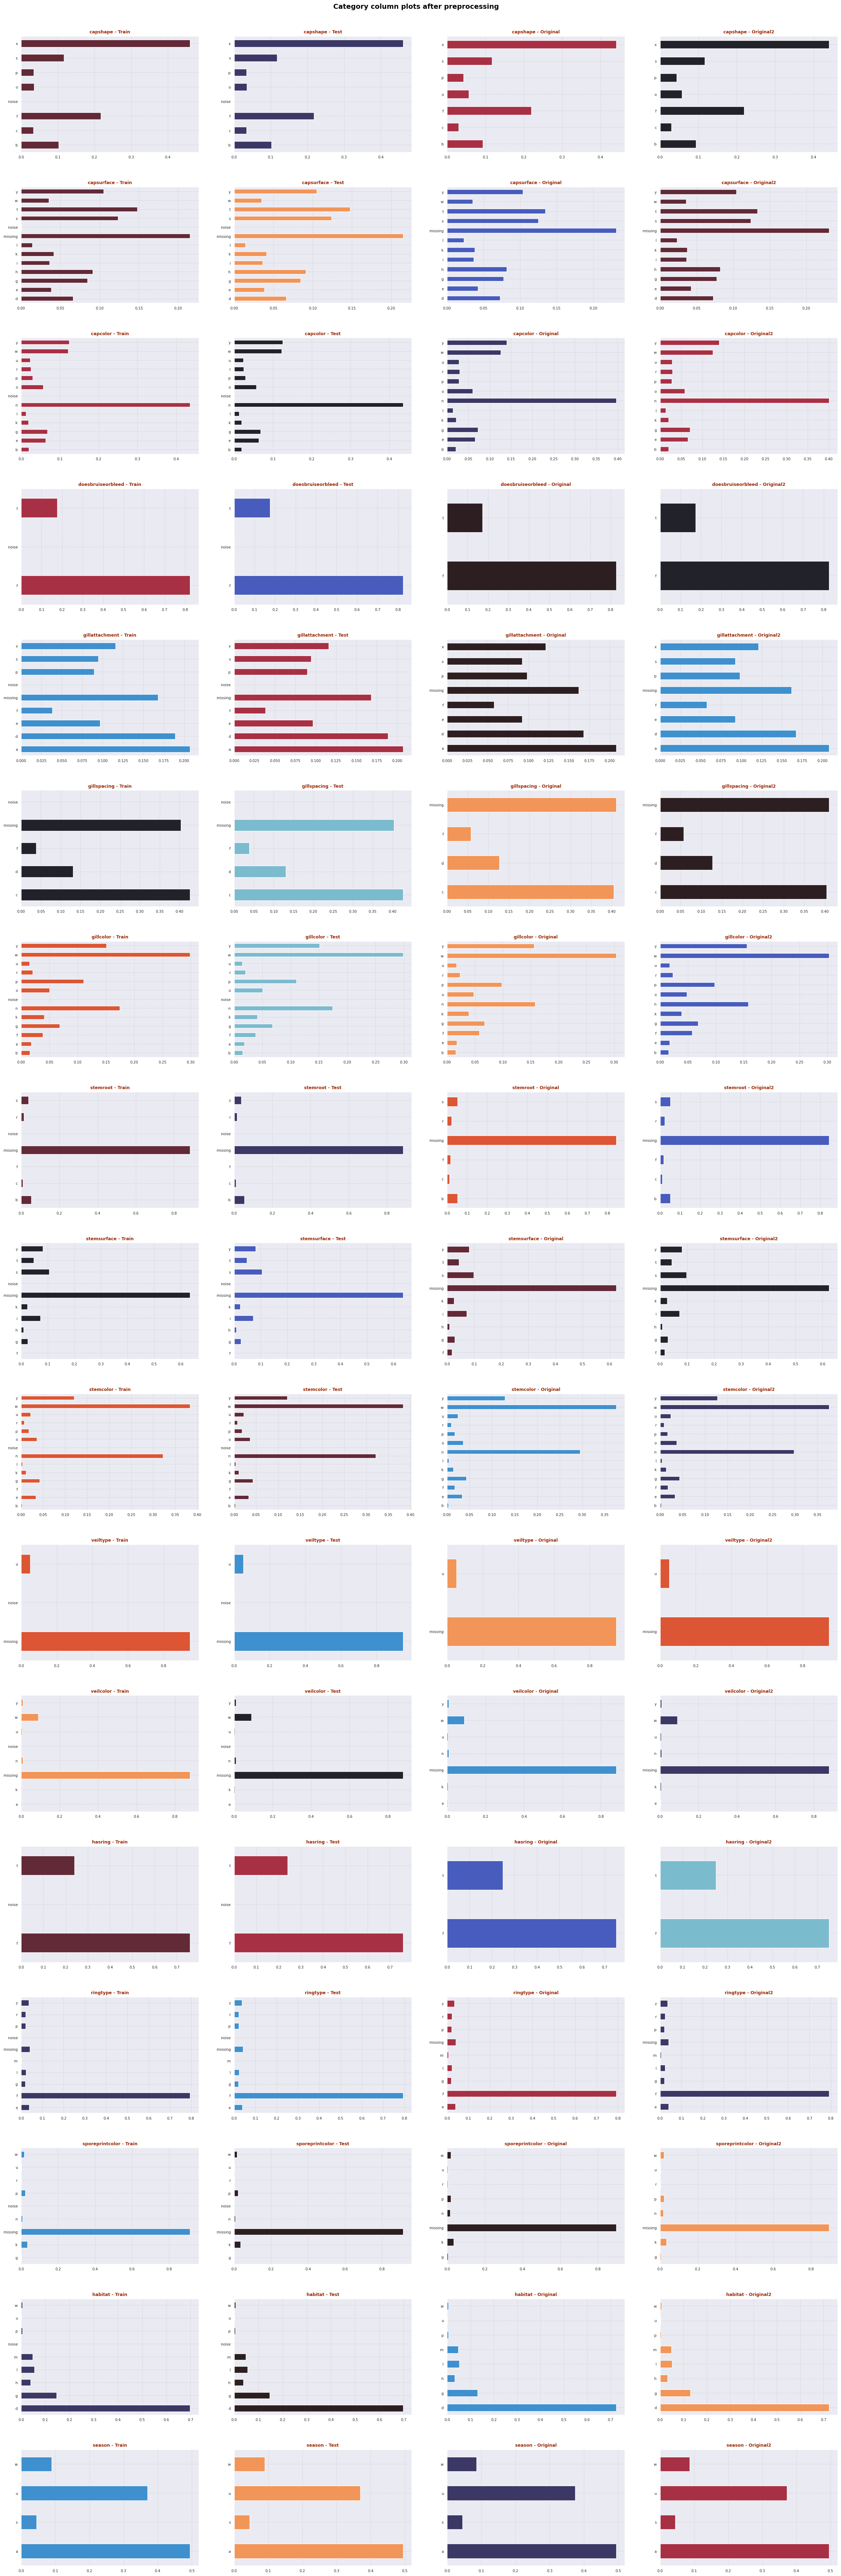


CPU times: user 24.9 s, sys: 392 ms, total: 25.3 s
Wall time: 25.1 s


In [5]:
%%time

if visuals_req:
    fig, axes = plt.subplots(len(cat_cols), 4, 
                             figsize = (30, 5.5 * len(cat_cols)),
                             gridspec_kw = {"hspace": 0.3, "wspace": 0.2}
                            )

    for j, col in tqdm(enumerate(cat_cols)):
        colors = sns.color_palette("icefire", n_colors = 10)

        for i, (label, df) in enumerate(df_dict.items()):
            ax = axes[j, i]
            df[col].value_counts(normalize = True).sort_index().\
            plot.barh(color = colors[np.random.randint(0, 10, 1)[0]], ax = ax)
            ax.set_title(f"{col} - {label}", **title_specs);
            ax.grid(**grid_specs);
            ax.set(ylabel = "")

    plt.tight_layout()
    plt.suptitle(f"Category column plots after preprocessing", 
                 y = 0.89, color = "black", fontsize = 14, fontweight = "bold",
                )
    plt.show()
    
print();
collect();

## **INFERENCES**

We note that the proprocessing helped us reduce stray categories into a common **noise** category <br>
Distributions across category columns are now aligned across datasets <br>

# **CLOSURE**

In [6]:
%%time 

try: 
    del df_dict
except: 
    pass

# Dropping duplicates in the original data
original = pd.concat([original[train.columns], orig[train.columns]], axis=0).drop_duplicates(keep = "first")
PrintColor(f"---> Original- Shape before drop = {original.shape}")
drop_idx = original.reset_index().merge(train, how = "inner", on = list(test.columns))["index"]
original = original.drop(drop_idx, axis=0)
PrintColor(f"---> Original- Shape after drop = {original.shape}")

try:
    for df in [train, original]:
        df[target] = df[target].map(mapper).astype(np.uint8)
except:
    pass

for df in [train, test]:
    df["Source"] = "Competition"

original["Source"] = "Original"
train = pd.concat([train, original[train.columns]], axis=0, ignore_index = True)
print(f"\n\n---> Shapes = {train.shape} | {test.shape}\n")

print()
display(train.groupby("Source").size())

train.index = range(len(train))                 
train.to_parquet("train.parquet")
test.to_parquet("test.parquet")
sub_fl.to_parquet("sample_submission.parquet")

%reset -f             

---> Original- Shape before drop = (1086525, 21)
---> Original- Shape after drop = (1085036, 21)


---> Shapes = (4201981, 22) | (2077964, 21)




Source
Competition    3116945
Original       1085036
dtype: int64

CPU times: user 25.7 s, sys: 2.62 s, total: 28.4 s
Wall time: 28.1 s
